In [1]:
import json
from pathlib import Path
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from io_f import read_data_file
from main import calibrate_magnetic_wifi_ibeacon_to_position, extract_magnetic_strength

## Prepare environment and read data
Adopted from the sample code

In [2]:
selected_floor = 'B1'
floor_data_dir = f'./data/site1/{selected_floor}'
path_data_dir = floor_data_dir + '/path_data_files'
floor_plan_filename = floor_data_dir + '/floor_image.png'
floor_info_filename = floor_data_dir + '/floor_info.json'

save_dir = f'./output/site1/{selected_floor}'
path_image_save_dir = save_dir + '/path_images'
step_position_image_save_dir = save_dir
magn_image_save_dir = save_dir
wifi_image_save_dir = save_dir + '/wifi_images'
ibeacon_image_save_dir = save_dir + '/ibeacon_images'
wifi_count_image_save_dir = save_dir
Path(path_image_save_dir).mkdir(parents=True, exist_ok=True)
Path(magn_image_save_dir).mkdir(parents=True, exist_ok=True)
Path(wifi_image_save_dir).mkdir(parents=True, exist_ok=True)
Path(ibeacon_image_save_dir).mkdir(parents=True, exist_ok=True)

In [3]:
with open(floor_info_filename) as f:
    floor_info = json.load(f)
width_meter = floor_info["map_info"]["width"]
height_meter = floor_info["map_info"]["height"]

path_filenames = list(Path(path_data_dir).resolve().glob("*.txt"))

### Visualization of Waypoints

Han Yaodong

In [4]:
def visualize_path(path_id, waypoints, width_meter, height_meter):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.add_line(plt.Line2D(waypoints[:, 0], waypoints[:, 1], marker='.', color='grey'))
    for i, xy in enumerate(waypoints):
        ax.annotate(i + 1, xy)
    ax.set_title(f'Waypoints for {path_id} at Floor {selected_floor}')
    ax.set_xlim([0, width_meter])
    ax.set_ylim([0, height_meter])
    return fig

In [5]:
# reading data and visualize paths
waypoints_list = []
for path_filename in path_filenames:
    path_data = read_data_file(path_filename)
    path_id = path_filename.name.split(".")[0]
    waypoints = path_data.waypoint[:, 1:3]
    waypoints_list.append(waypoints)
    
    # paths
    fig = visualize_path(path_id, waypoints, width_meter, height_meter)
    fig.savefig(f'{path_image_save_dir}/{path_id}.png')
    plt.close(fig)

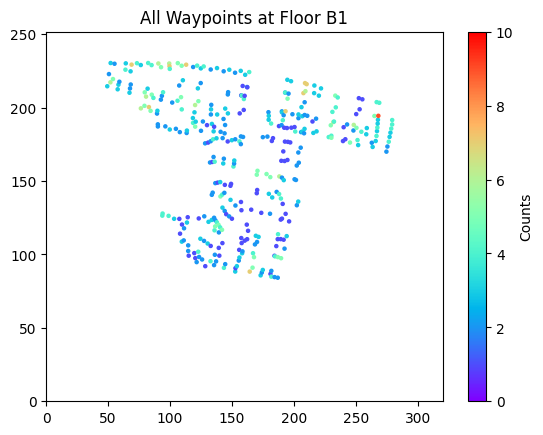

In [6]:
# visualize waypoints
all_waypoints = np.concatenate(waypoints_list)
unique_waypoints, counts = np.unique(all_waypoints, axis=0, return_counts=True)

fig = plt.figure()
ax = fig.add_subplot()
sc = plt.scatter(unique_waypoints[:, 0], unique_waypoints[:, 1], s=20, c=counts, marker='.', cmap='rainbow', vmin=0, vmax=10)
cbar = plt.colorbar(sc)
cbar.set_label("Counts")
ax.set_title(f'All Waypoints at Floor {selected_floor}')
ax.set_xlim([0, width_meter])
ax.set_ylim([0, height_meter + 20])
fig.savefig(f'{save_dir}/waypoints.png')

### Visualization of Geomagnetic Strength
Ben

In [7]:
#The following function is developed to plot the different sets of GeoMagnetic Strength X,Y,Z at same position, in order to identify the outliners
def plot_sensor_info(df, name):
    cols = ["x", "y", "z"]
    plt.subplots(1, 1, sharex='col', sharey='row', figsize=(8,5))
    plt.suptitle(name, fontsize=22)
    plt.plot(df['time'], df['z'], color='#000000', label='z_axis')
    plt.plot(df['time'], df['y'], color='#d6b258', label='y_axis')
    plt.plot(df['time'], df['x'], color='#96bcfa', label='x_axis')
    plt.xlabel('Time')
    plt.ylabel('Sensor Value')
    plt.legend()
    plt.show()

   
def revised_extract_magnetic_strength(mwi_datas):
    magnetic_strength = {}
    for position_key in mwi_datas:
        magnetic_data = mwi_datas[position_key]['magnetic']
        df = pd.DataFrame(magnetic_data, columns=['time', 'x', 'y', 'z'])
        magnetic_s = np.mean(np.sqrt(np.sum(magnetic_data[:, 1:4] ** 2, axis=1)))
        #
        #Below codes are to calculate if the X,Y,Z deviate too much across different measurement at same step positions, 
        #in order to identify noise
        #calculate mean and variance
        x_mean = np.mean(magnetic_data[:, 1])
        y_mean = np.mean(magnetic_data[:, 2])
        z_mean = np.mean(magnetic_data[:, 3])
        variance_magn_data=magnetic_data
        variance_magn_data[:, 1] -= x_mean
        variance_magn_data[:, 2] -= y_mean
        variance_magn_data[:, 3] -= z_mean
        variance_mean= np.mean(np.sqrt(np.sum(variance_magn_data[:, 1:4] ** 2, axis=1)))
        print("this is the position of below magnetic data measurement",position_key)
        print("variance is:",variance_mean)
        #
        #Set a threshold 4 such that if average variance of X,Y,Z greater than 4, 
        #such measurement is removed from the dataset, in order to create a clean and quality dataset for future training
        threshold=4
        if variance_mean < threshold:
           magnetic_strength[position_key] = magnetic_s
        #Enable line if need to capture the plot of outliner as it take long time to process 1000+ ploting.
        #if variance_mean >= threshold:
        #    #plot_sensor_info(df, "GeoMagnetic data")
        #
        #Enable below line instead of above if need to capture the plot of all X,Y,Z in different step positions
        #plot_sensor_info(df, "GeoMagnetic data")
    total_keys_before_cleanup = len(mwi_datas)
    total_keys_post_cleanup = len(magnetic_strength)
    print("total positions before cleanup are:",total_keys_before_cleanup, "total positions after removing variance>=4:",total_keys_post_cleanup)
    return magnetic_strength


In [8]:
mwi_datas = calibrate_magnetic_wifi_ibeacon_to_position(path_filenames)

Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5dda14979191710006b5720e.txt...
Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5dda1499c5b77e0006b1752f.txt...
Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5dda149dc5b77e0006b17531.txt...
Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5dda149f9191710006b57212.txt...
Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5dda14a2c5b77e0006b17533.txt...
Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5dda14a39191710006b57214.txt...
Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5dda14a5c5b77e0006b17535.txt...
Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5dda14a791917100

Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5dda33409191710006b57330.txt...
Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5dda33409191710006b57332.txt...
Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5dda33429191710006b57334.txt...
Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5dda33429191710006b57336.txt...
Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5dda3342c5b77e0006b17646.txt...
Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5dda3343c5b77e0006b17648.txt...
Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5dda33449191710006b57338.txt...
Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5dda3344c5b77e00

Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5ddb930cc5b77e0006b179aa.txt...
Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5ddb930dc5b77e0006b179ac.txt...
Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5ddb930e9191710006b57645.txt...
Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5ddb949cc5b77e0006b179ae.txt...
Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5de8c24d376b9d0006fdaa23.txt...
Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5de8c24d7491b00006eaafdb.txt...
Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5de8c709376b9d0006fdaa35.txt...
Processing C:\Users\yupen\Desktop\AI6128\project1\codes\project1\data\site1\B1\path_data_files\5de8c70b376b9d00

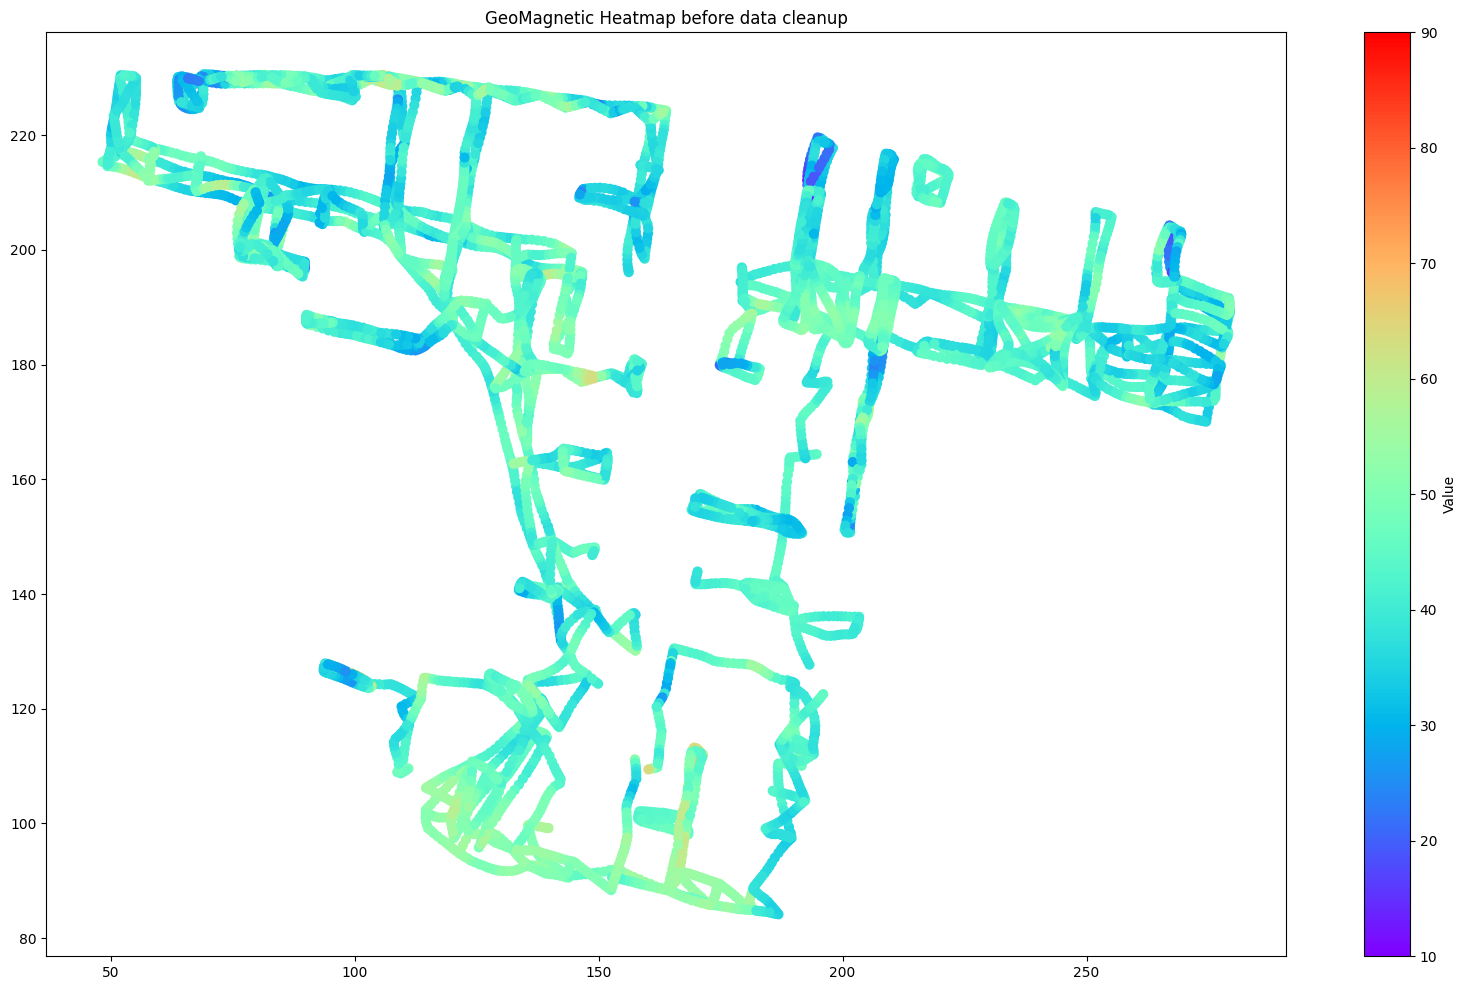

In [9]:
#visualize magnetic heatmap before data cleanup

# Define global color scale limits so all heatmaps are consistent for comparison
global_vmin = 10  # replace with your desired minimum value
global_vmax = 90   # replace with your desired maximum value
#
magnetic_strength = extract_magnetic_strength(mwi_datas)
position = np.array(list(magnetic_strength.keys()))
value = np.array(list(magnetic_strength.values()))
colorbar_title = "Value"
title = "GeoMagnetic Heatmap before data cleanup"

# Create a scatter plot
plt.figure(figsize=(20, 12))
sc = plt.scatter(position[:, 0], position[:, 1], c=value, s=40, cmap='rainbow', vmin=global_vmin, vmax=global_vmax)  

# Add a colorbar
cbar = plt.colorbar(sc)
cbar.set_label(colorbar_title)

# Set the title
plt.title(title)

# Show the plot
plt.show()

this is the position of below magnetic data measurement (209.69723958981075, 216.295877202169)
variance is: 1.5848153474957059
this is the position of below magnetic data measurement (210.03210715991432, 215.59844570817322)
variance is: 12.282551946548725
this is the position of below magnetic data measurement (209.43788005605913, 214.55064770929746)
variance is: 3.729406901214399
this is the position of below magnetic data measurement (208.32696913629445, 212.00342872258008)
variance is: 2.2489769502605523
this is the position of below magnetic data measurement (207.48692119137223, 209.25215211596736)
variance is: 1.7347143071026598
this is the position of below magnetic data measurement (206.85886710899754, 207.5113350225912)
variance is: 2.127255134360843
this is the position of below magnetic data measurement (205.93897030356965, 204.92744283815102)
variance is: 1.684747649071558
this is the position of below magnetic data measurement (205.82008209386183, 202.965823808006)
variance

this is the position of below magnetic data measurement (93.754005, 126.45866)
variance is: 16.83229017172406
this is the position of below magnetic data measurement (112.89679586118051, 122.02798915984324)
variance is: 2.6498773341508195
this is the position of below magnetic data measurement (112.24051393268664, 122.28566945518833)
variance is: 2.539218900276237
this is the position of below magnetic data measurement (106.81885584129381, 124.25620504048277)
variance is: 3.788769627035961
this is the position of below magnetic data measurement (93.79640758634791, 126.93883960350729)
variance is: 2.2170745673871175
this is the position of below magnetic data measurement (113.32719576086333, 121.84629474608283)
variance is: 2.4069970053517427
this is the position of below magnetic data measurement (110.96394626540274, 122.84277256603322)
variance is: 3.177618411216239
this is the position of below magnetic data measurement (110.32689215562364, 123.1519691827018)
variance is: 2.472531220

this is the position of below magnetic data measurement (68.50941012465411, 216.29011921660964)
variance is: 12.519949517527703
this is the position of below magnetic data measurement (68.22799124954405, 214.5959653323661)
variance is: 2.5877371853403255
this is the position of below magnetic data measurement (68.05300116277257, 213.8965839845941)
variance is: 2.4475997456931466
this is the position of below magnetic data measurement (67.55573266546455, 211.66064220506968)
variance is: 2.2541888975747093
this is the position of below magnetic data measurement (67.38289297752272, 210.90433152300972)
variance is: 2.3762716816616116
this is the position of below magnetic data measurement (67.6417683863167, 210.21919395945278)
variance is: 13.591631085660344
this is the position of below magnetic data measurement (68.98839002519435, 210.62930193345943)
variance is: 3.7980212182420034
this is the position of below magnetic data measurement (69.88074530050949, 210.91559971521863)
variance is

this is the position of below magnetic data measurement (177.37391220353348, 180.16643793886317)
variance is: 1.8406350240129192
this is the position of below magnetic data measurement (176.77359423243115, 180.09183543736216)
variance is: 1.6913580970407875
this is the position of below magnetic data measurement (175.44865265706383, 179.96890515381236)
variance is: 1.6523696000228836
this is the position of below magnetic data measurement (176.805704119297, 185.47304424685012)
variance is: 4.085578472764668
this is the position of below magnetic data measurement (180.4051339526435, 188.32161043615886)
variance is: 2.9425590222270395
this is the position of below magnetic data measurement (155.91784170333847, 197.47622364152696)
variance is: 5.636509130336011
this is the position of below magnetic data measurement (156.06682499520983, 200.85277144178957)
variance is: 4.148406029373233
this is the position of below magnetic data measurement (156.90475204838376, 204.11457234999855)
varian

this is the position of below magnetic data measurement (203.66004004431974, 169.94019204514356)
variance is: 8.41861637159024
this is the position of below magnetic data measurement (203.54718871012648, 169.02277462956937)
variance is: 3.349786448407321
this is the position of below magnetic data measurement (203.63622926718972, 168.45346514179477)
variance is: 2.972396916294262
this is the position of below magnetic data measurement (203.77374310193642, 166.1830043011082)
variance is: 3.445343571009746
this is the position of below magnetic data measurement (203.83877902945972, 165.31140453871674)
variance is: 3.34166727654923
this is the position of below magnetic data measurement (203.85488043247324, 163.22822709970472)
variance is: 2.1004424346261943
this is the position of below magnetic data measurement (202.07355212869004, 160.08502647494936)
variance is: 10.447932027174847
this is the position of below magnetic data measurement (201.8457975931762, 158.9664704580867)
variance i

this is the position of below magnetic data measurement (200.98877, 183.76555)
variance is: 13.19080707942795
this is the position of below magnetic data measurement (193.60955485929247, 197.51927460266253)
variance is: 2.964318110325295
this is the position of below magnetic data measurement (194.8374878958374, 197.38462144005683)
variance is: 2.2176679944982993
this is the position of below magnetic data measurement (195.51763588146213, 197.27596899303367)
variance is: 2.528579349375122
this is the position of below magnetic data measurement (196.88545572801243, 196.85418808639648)
variance is: 2.2361852082179325
this is the position of below magnetic data measurement (197.54300820100062, 196.49857145455883)
variance is: 2.305037376764661
this is the position of below magnetic data measurement (198.1714804623533, 196.09612397098329)
variance is: 1.9367648728354863
this is the position of below magnetic data measurement (199.09498534661572, 195.0903169426677)
variance is: 1.7967920347

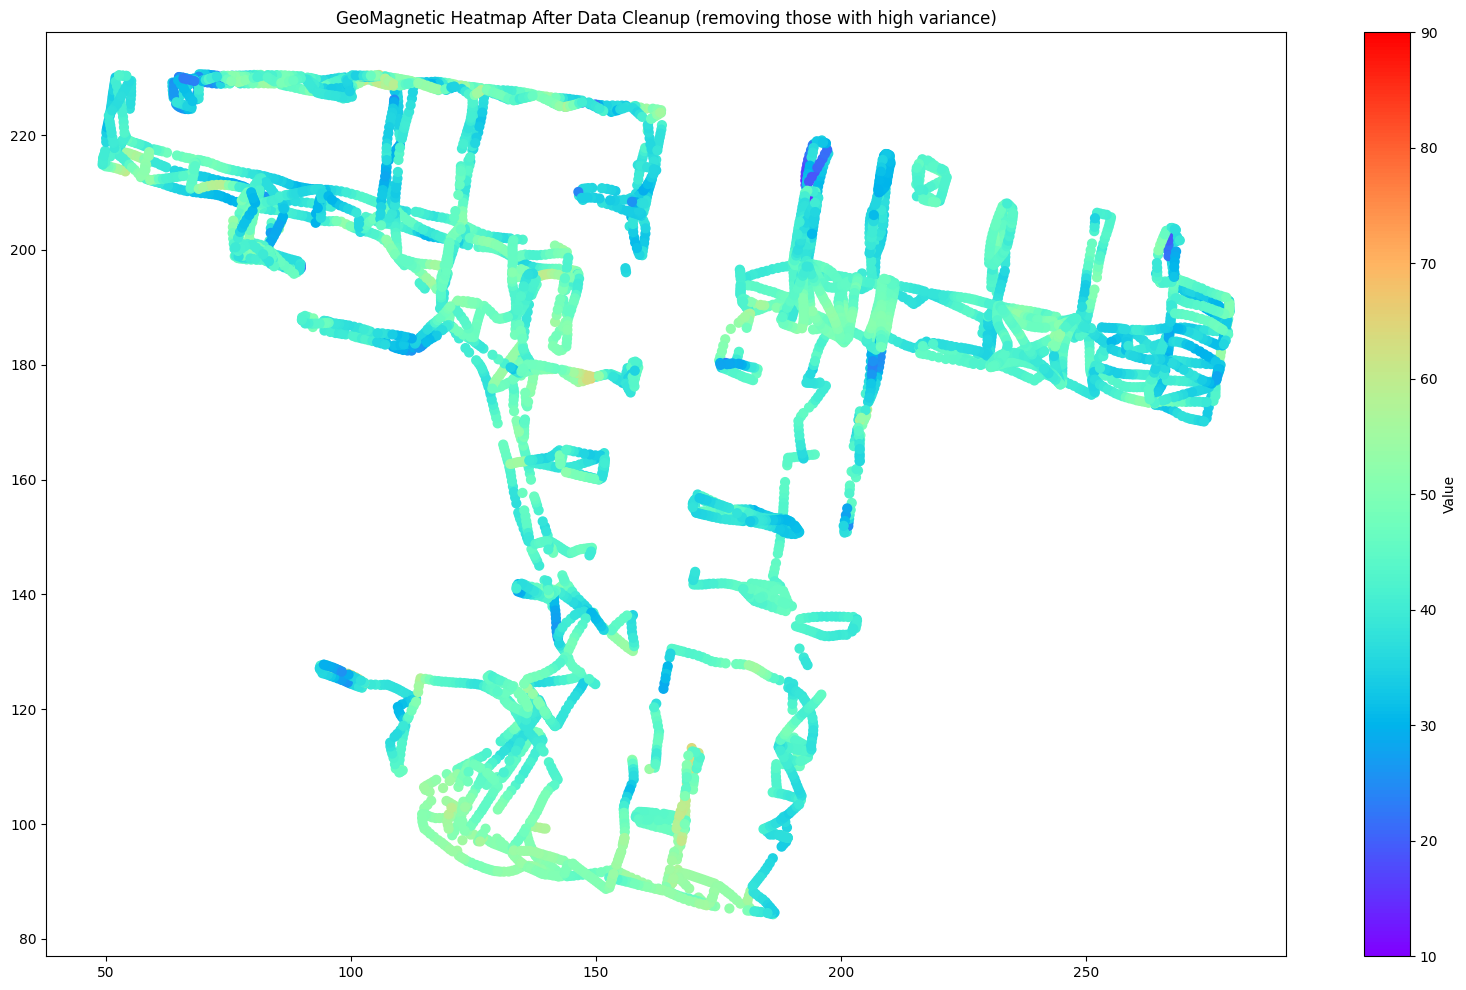

In [10]:
#visualize magnetic heatmap after data cleanup
#
# Define global color scale limits so all heat maps are consistent for comparison
global_vmin = 10  # replace with your desired minimum value
global_vmax = 90   # replace with your desired maximum value
#
new_magnetic_strength = revised_extract_magnetic_strength(mwi_datas)
position = np.array(list(new_magnetic_strength.keys()))
value = np.array(list(new_magnetic_strength.values()))
colorbar_title = "Value"
title = "GeoMagnetic Heatmap After Data Cleanup (removing those with high variance)"

# Create a scatter plot
plt.figure(figsize=(20, 12))
sc = plt.scatter(position[:, 0], position[:, 1], c=value, s=40, cmap='rainbow', vmin=global_vmin, vmax=global_vmax)  

# Add a colorbar
cbar = plt.colorbar(sc)
cbar.set_label(colorbar_title)

# Set the title
plt.title(title)

# Show the plot
plt.show()

### Visualization on Wifi
Huang Yupeng

In [11]:
def plotRSSIForRouter(bssid, rssi_for_router, floor):
    n = len(rssi_for_router[bssid])
    dataToPlot = np.zeros((n, 3))

    #some position has matched with multiple measurements, average them together
    for i, (loc, value) in enumerate(rssi_for_router[bssid].items()):
        dataToPlot[i][0] = loc[0]
        dataToPlot[i][1] = loc[1]
        dataToPlot[i][2] = np.mean(value)

    colorbar_title = "Average RSSI"
    title = "Average RSSI measured at bssid:" + bssid + " at " + floor
    plt.figure(figsize=(10, 6))
    sc = plt.scatter(dataToPlot[:, 0], dataToPlot[:, 1], c=dataToPlot[:, 2], s=40, cmap='rainbow')

    cbar = plt.colorbar(sc)
    cbar.set_label(colorbar_title)
    plt.title(title)
    plt.show()
    
def tidyDataForRouter(mwi_datas):
    rssi_for_router = {}
    for loc, mwi_data in mwi_datas.items():
        wifi_datas = mwi_data['wifi']
        for wifi_data in wifi_datas:
            bssid = wifi_data[2]
            rssi = int(wifi_data[3])
            if not (bssid in rssi_for_router.keys()):
                rssi_for_router[bssid] = {}
            if not (loc in rssi_for_router[bssid].keys()):
                rssi_for_router[bssid][loc] = []

            rssi_for_router[bssid][loc].append(rssi)
    return rssi_for_router

In [12]:
collectedData = {}
rssi_for_router  = tidyDataForRouter(mwi_datas)

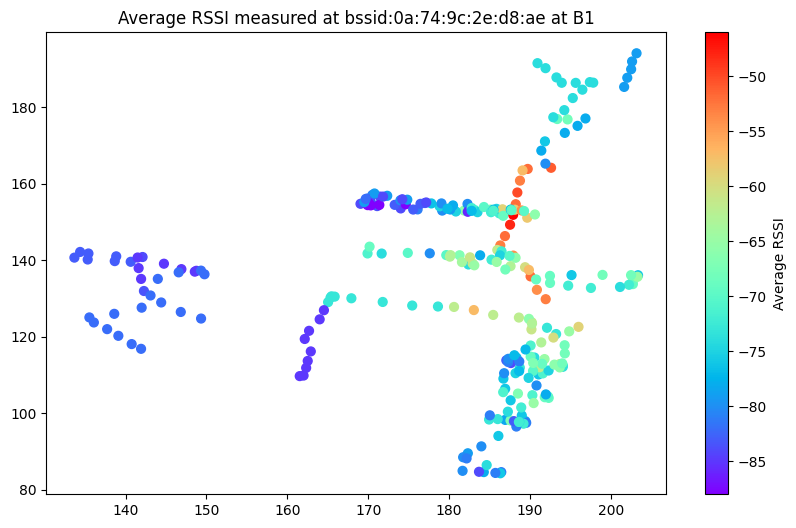

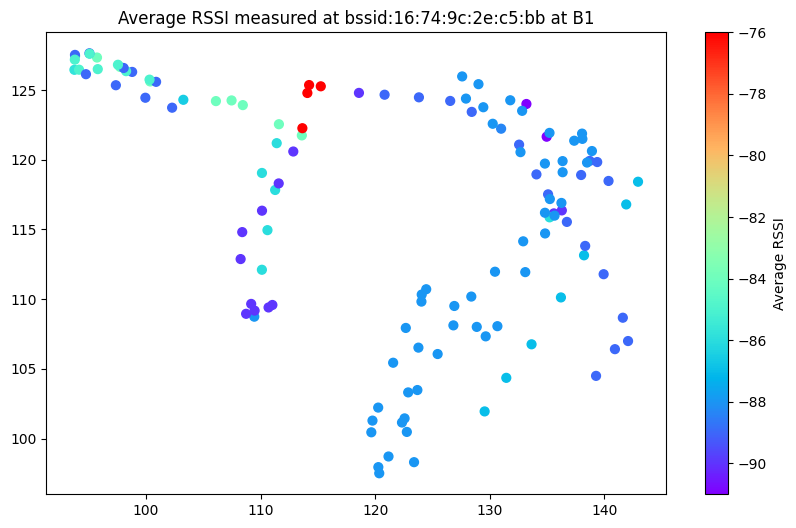

In [13]:
#two random router is selected for display
sampledRouters = random.sample(list(rssi_for_router.keys()), 2)
for bssid in sampledRouters:
    plotRSSIForRouter(bssid, rssi_for_router, selected_floor)

In [14]:
def getMaxDiff(positionRssiPair):
    max_diff = 0
    for strength_list in positionRssiPair.values():
        diff = max(strength_list) - min(strength_list)
        max_diff = max(max_diff, diff)
    return max_diff

def getCount(positionRssiPair):
    count = 0
    for strength_list in positionRssiPair.values():
        count += len(strength_list)
    return count

In [15]:
max_diff = []
count = []
for key, value in rssi_for_router.items():
    max_diff.append(getMaxDiff(value))
    count.append(getCount(value))

Text(0, 0.5, 'Count')

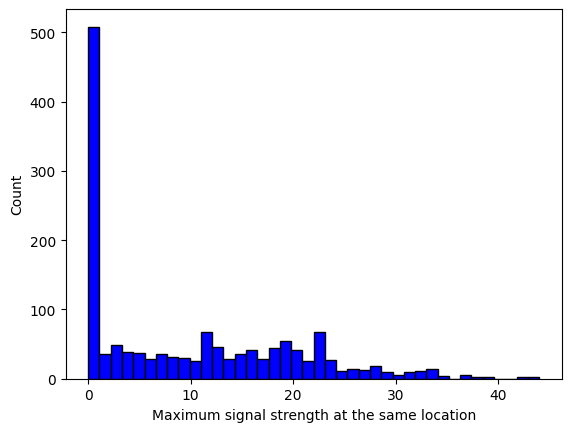

In [16]:
#checking the max signal strength found on each router
#to check on how many router is likely to be placed far from experiment field
plt.hist(max_diff, bins=40, color='blue', edgecolor='black')
plt.xlabel('Maximum signal strength at the same location')
plt.ylabel('Count')

(1, 1216)


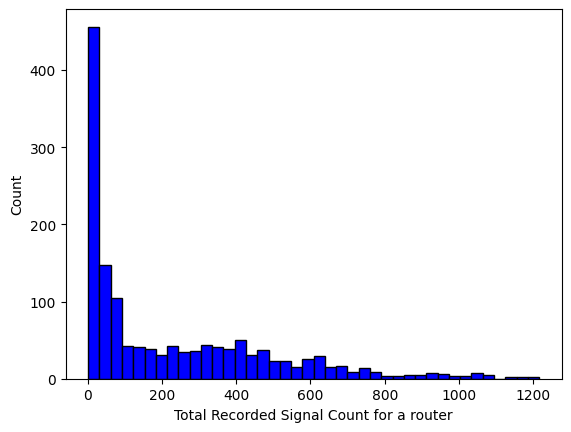

In [17]:
#checking the number of measurement found on each router
plt.hist(count, bins=40, color='blue', edgecolor='black')

plt.xlabel('Total Recorded Signal Count for a router')
plt.ylabel('Count')

print((min(count), max(count)))